# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings 
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Download Dataset

In [2]:
def load_stock_data(ticker = 'AAPL', start = '2025-01-01'):
    df = yf.download(ticker, start = start)
    df.reset_index(inplace = True)
    print('Data downloaded:',df.shape)
    return df

df = load_stock_data('AAPL')
df.head()

[*********************100%***********************]  1 of 1 completed

Data downloaded: (224, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2025-01-02,242.752090,247.978453,240.731232,247.809205,55740700
1,2025-01-03,242.264297,243.080598,240.800915,242.264297,40244100
2,2025-01-06,243.896912,246.216423,242.105013,243.210016,45045600
3,2025-01-07,241.119476,244.444435,240.263348,241.885999,40856000
4,2025-01-08,241.607269,242.612732,238.969207,240.830782,37628900


# EDA

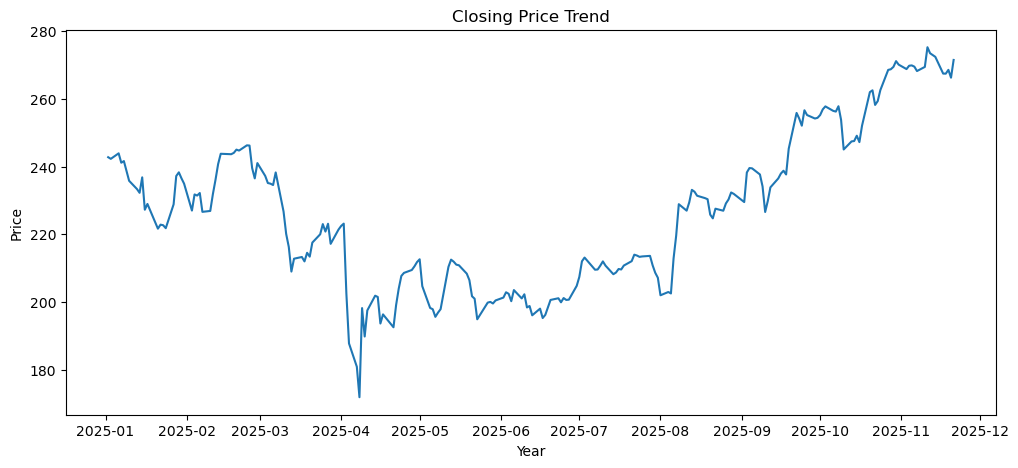

In [3]:
# Plot Closing Price Trend

plt.figure(figsize=(12,5))
plt.plot(df['Date'],df['Close'])
plt.title('Closing Price Trend')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

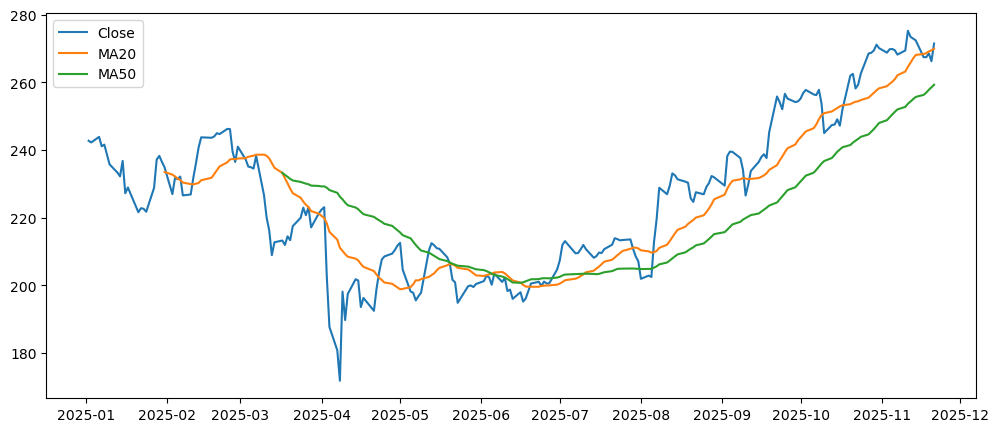

In [4]:
# Moving Averages

df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()

plt.figure(figsize = (12,5))
plt.plot(df['Date'], df['Close'], label = 'Close')
plt.plot(df['Date'], df['MA20'], label = 'MA20')
plt.plot(df['Date'], df['MA50'], label = 'MA50')

plt.legend()
plt.show()

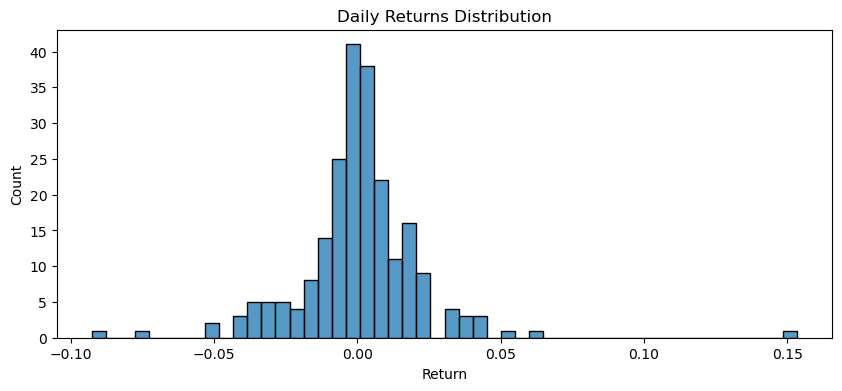

In [5]:
# Daily Returns

df['Return'] = df['Close'].pct_change()

plt.figure(figsize = (10,4))
sns.histplot(df['Return'].dropna(),bins = 50)
plt.title("Daily Returns Distribution")
plt.show()

In [6]:
# Correlation 

corr = df.corr()

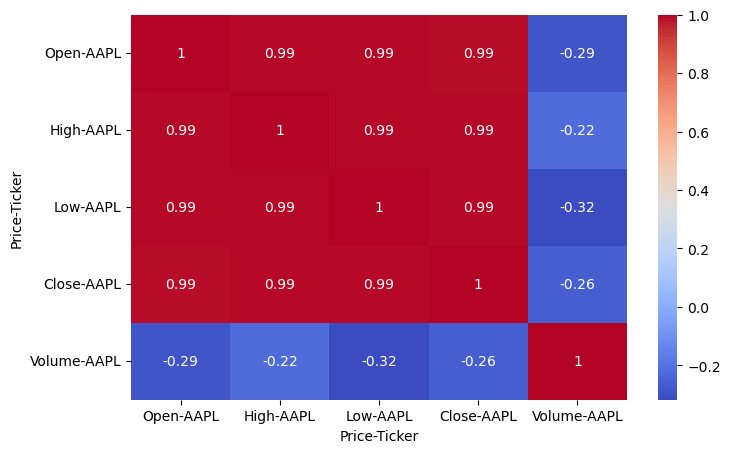

In [7]:
# Correaltion Heatmap

plt.figure(figsize=(8,5))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot = True, cmap = 'coolwarm')
plt.show()

# Feature Engineering

In [19]:
def create_features(df):
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)

    # lag features
    df['lag1'] = df['Close'].shift(1)
    df['lag2'] = df['Close'].shift(2)
    df['lag3'] = df['Close'].shift(3)

    # returns
    df['return_1d'] = df['Close'].pct_change()

    # rolling features (small windows so they don't remove too many rows)
    df['roll_mean_7'] = df['Close'].rolling(7).mean()
    df['roll_std_7'] = df['Close'].rolling(7).std()

    # target (next-day price)
    df['target'] = df['Close'].shift(-1)

    # ALWAYS remove all NaNs at the end
    df = df.dropna().reset_index(drop=True)

    return df
df_feat = create_features(df)
df_feat.head()

Price,Date,Close,High,Low,Open,Volume,MA20,MA50,Return,lag1,lag2,lag3,return_1d,roll_mean_7,roll_std_7,target
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,
0,2025-03-17,213.270721,214.486565,209.254456,212.583070,48073400,233.248902,233.275303,0.002389,212.762466,208.965424,216.240570,0.002389,219.469524,10.081401,211.965195
1,2025-03-18,211.965195,214.416803,210.769287,213.430186,42432400,231.665318,232.659565,-0.006121,213.270721,212.762466,208.965424,-0.006121,215.713795,5.978840,214.506500
2,2025-03-19,214.506500,218.014494,213.021572,213.489972,54385400,230.188868,232.104409,0.011989,211.965195,213.270721,212.762466,0.011989,213.971185,3.508995,213.370377
3,2025-03-20,213.370377,216.748823,211.496779,213.260751,48862900,228.607775,231.493878,-0.005296,214.506500,211.965195,213.270721,-0.005296,213.011608,2.250386,217.526184
4,2025-03-21,217.526184,218.094234,210.559999,210.839044,94127800,227.248425,231.022012,0.019477,213.370377,214.506500,211.965195,0.019477,213.195267,2.585359,219.977783


# Drop NaN values

In [20]:
df.isnull().sum()

Price   Ticker
Date               0
Close   AAPL       0
High    AAPL       0
Low     AAPL       0
Open    AAPL       0
Volume  AAPL       0
MA20              19
MA50              49
Return             1
dtype: int64

In [21]:
df.dropna()

Price,Date,Close,High,Low,Open,Volume,MA20,MA50,Return
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,
49,2025-03-17,213.270721,214.486565,209.254456,212.583070,48073400,233.248902,233.275303,0.002389
50,2025-03-18,211.965195,214.416803,210.769287,213.430186,42432400,231.665318,232.659565,-0.006121
51,2025-03-19,214.506500,218.014494,213.021572,213.489972,54385400,230.188868,232.104409,0.011989
52,2025-03-20,213.370377,216.748823,211.496779,213.260751,48862900,228.607775,231.493878,-0.005296
53,2025-03-21,217.526184,218.094234,210.559999,210.839044,94127800,227.248425,231.022012,0.019477
...,...,...,...,...,...,...,...,...,...
219,2025-11-17,267.459991,270.489990,265.730011,268.820007,45018300,268.385876,256.301161,-0.018171
220,2025-11-18,267.440002,270.709991,265.320007,269.989990,45677300,268.632101,256.967501,-0.000075
221,2025-11-19,268.559998,272.209991,265.500000,265.529999,40424500,269.150116,257.807293,0.004188


In [22]:
df.isnull().sum()

Price   Ticker
Date               0
Close   AAPL       0
High    AAPL       0
Low     AAPL       0
Open    AAPL       0
Volume  AAPL       0
MA20              19
MA50              49
Return             1
dtype: int64

# Train ML Model

In [23]:
features = ['lag1','lag2','lag3','return_1d','roll_mean_7','roll_std_7']
X = df_feat[features]
y = df_feat['target']

tscv = TimeSeriesSplit(n_splits = 5)
model = RandomForestRegressor(n_estimators = 200, random_state = 42)

rmses = []
for train_index, test_index in tscv.split(X):
    X_train, X_test= X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    rmses.append(rmse)
    
print('Average RMSE:', np.mean(rmses))

Average RMSE: 12.12502540681921


In [24]:
# Real-Time Prediction

def predict_next_day(df, model):
    last = df.tail(1)
    X_last = last[features]
    pred = model.predict(X_last)[0]
    return pred

next_day_price = predict_next_day(df_feat,model)
print('Predicted next-day close:',next_day_price)

Predicted next-day close: 253.609154586792
